In [1]:
# Install packages
import pandas as pd
from sklearn.preprocessing import normalize
import numpy as np
import pystan
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas
import seaborn

In [40]:
# Import data
data = pd.read_csv("/Users/ritakurban/Downloads/final.csv", skiprows = 44, names = ["Date", "CO2"])

In [41]:
# Transform dates into days from the first observation (deltas)
from datetime import datetime, timedelta
date_format = "%Y-%m-%d"
deltas = [0]
delta = 0
for i in range(len(data.Date)-1):
    a = datetime.strptime(str(data.Date[i]), date_format)
    b = datetime.strptime(str(data.Date[i+1]), date_format)
    delta += (b-a).days
    deltas.append(delta)

# Create a new column    
data["Deltas"] = deltas

In [42]:
# Calculate days until 01.01.2058
last_pred = datetime.strptime(str(data.Date[len(data.Date)-1]), date_format)
pred_date= datetime.strptime("2058-01-01", date_format)

# Calculate weeks until the prediction day (to use in Stan)
n_future = (pred_date-last_pred).days/7+1

In [63]:
def days_to_years(day, date = False):
    """ Function that transforms days to years."""
    first_date= datetime.strptime("1958-03-29", date_format)
    current_date = first_date +  timedelta(days=day)
    if date == True:
        print current_date.date()
    else:
        return current_date.year

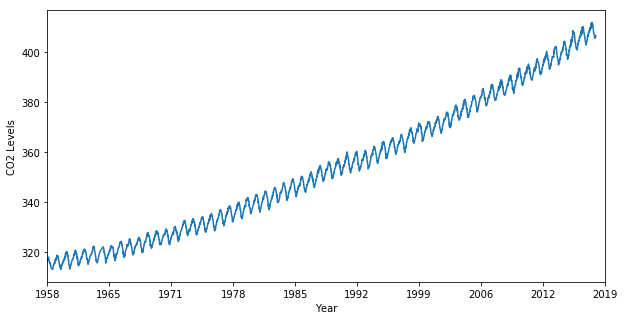

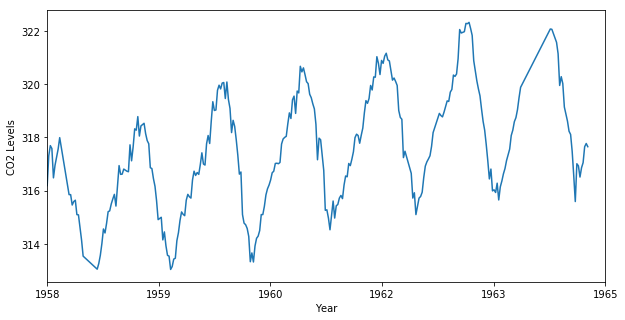

In [219]:
# Plot the data from 1958 to 2018 and a zoomed in trend
plt.figure(figsize=(10, 5))
plt.plot(data.Deltas,data.CO2)
plt.xlim(min(data.Deltas), max(data.Deltas))
locs, labels = plt.xticks() 
plt.xticks(locs, [days_to_years(loc) for loc in locs])
plt.xlabel('Year')
plt.ylabel('CO2 Levels')
plt.show()
plt.figure(figsize=(10, 5))

# The first 300 ibservations
plt.plot(data.Deltas[:300],data.CO2[:300])
plt.xlim(min(data.Deltas[:300]), max(data.Deltas[:300]))
locs, labels = plt.xticks() 
plt.xticks(locs, [days_to_years(loc) for loc in locs])
plt.xlabel('Year')
plt.ylabel('CO2 Levels')
plt.show()

In [81]:
# Set number of observations and the number of predictions
n = len(data.CO2)
n_future = n_future #I want to predicts some of the values in the obserwed range to see how they fit

In [82]:
# The Stan model. 
# Running this cell compiles the Stan model, which takes some time.

stan_data = {
    'n': n,
    'n_future': n_future,
    'x': data['CO2'][:n],
    'delta': data['Deltas'][:n]}  

stan_code = """
data {
    int<lower=0> n;        // The number of data
    real x[n];             // The data
    int<lower=0> n_future; // The number of future values to predict
    real delta[n];         // Days since the first observation
}

parameters {
    real<lower=0> c0;               // Intercept
    real<lower=0> c1_1;             // Linear trend
    real<lower=0> c1_2;             // Quadratic trend
    real<lower=0> c2;               // Amplitude
    real<lower=0,upper=pi()> c3;    // Phase
    real<lower=0> c4;               // Noise
}


model {
    c0 ~ normal(400,100); //Priors
    c1_1 ~ normal(0, 1);
    c1_2 ~ normal(0, 1);
    c2 ~ normal(0, 1);
    c3 ~ cauchy(0, 10);
    c4 ~ gamma(1, 0.3);
    
    for(t in 1:n) {
        x[t] ~ normal(
            c0 +
            c1_1*delta[t] + 
            c1_2*delta[t]^2 + 
            c2*sin((2*pi()*delta[t]/365.25 +c3) - sin(2*pi()*delta[t]/365.25 +c3)/2), c4); // Likelihood function
    }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {
    real x_future[n_future];
    for(t in 1:n_future) {
        x_future[t] = normal_rng(
            c0 + 
            c1_1*(delta[n] + 7 * t) + 
            c1_2*(delta[n] + 7 * t)^2 + 
            c2*sin((2*pi()*(delta[n] + 7 * t)/365.25 + c3) - sin(2*pi()*(delta[n] + 7 * t)/365.25 + c3)/2), c4);
    }
}
"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bf25ba91b0fa1d5468e5bcdb46b21626 NOW.


In [83]:
# Run Hamiltonian Monte Carlo using Stan with 4 Markov chains, a 1000 step
# warm-up phase and 1000 step sampling phase for each chain. The warm-up samples
# are discarded, so we are left with 4 x 1000 = 4000 samples.

# This cell will take around 10 minutes to run.

parameters = ['c0', 'c1_1', 'c1_2', 'c2', 'c3', 'c4']

results = stan_model.sampling(data=stan_data)

# Print summary
print(results.stansummary(pars=parameters))
samples = results.extract()


Inference for Stan model: anon_model_bf25ba91b0fa1d5468e5bcdb46b21626.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0   314.49  7.9e-4   0.05 314.41 314.46  314.5 314.53 314.58 3238.0    1.0
c1_1 2.1e-3  1.7e-7 9.3e-6 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2943.0    1.0
c1_2 9.6e-8 7.4e-124.0e-10 9.5e-8 9.5e-8 9.6e-8 9.6e-8 9.7e-8 2956.0    1.0
c2     3.14  4.4e-4   0.02    3.1   3.12   3.14   3.15   3.18 2418.0    1.0
c3     1.12  1.4e-4 6.3e-3   1.11   1.12   1.12   1.13   1.13 2088.0    1.0
c4     0.81  1.8e-4   0.01   0.79    0.8   0.81   0.82   0.83 3310.0    1.0

Samples were drawn using NUTS at Wed Dec 19 16:27:03 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


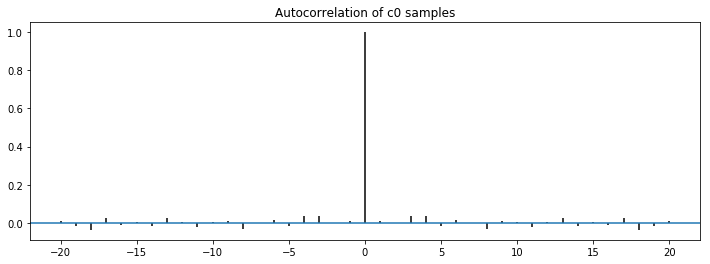

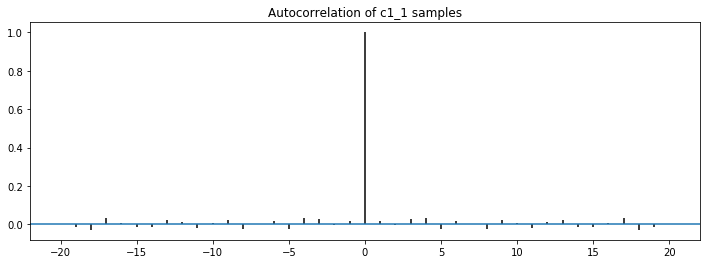

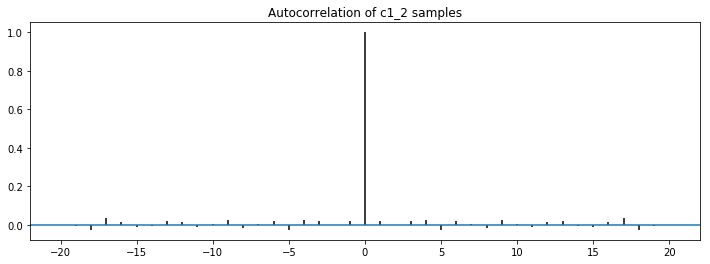

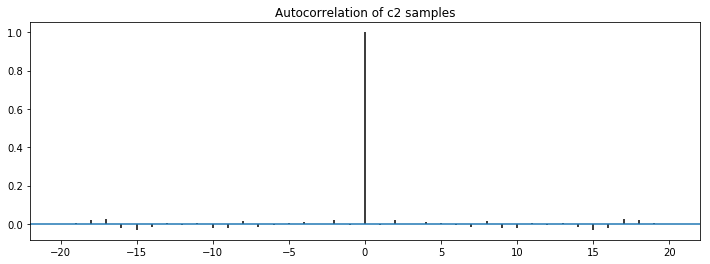

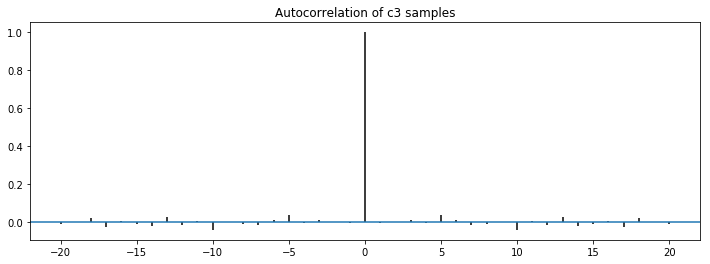

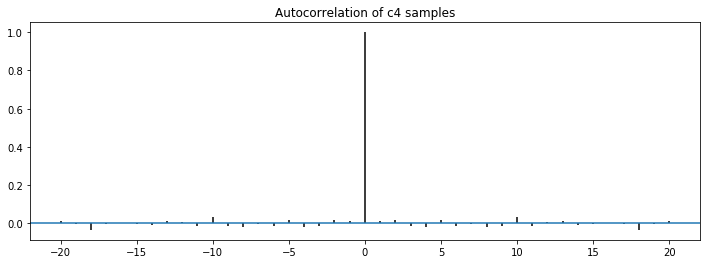

In [84]:
# Plot sample autocorrelation for each parameter.

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x.The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title('Autocorrelation of %s samples' % (param))

plt.show()

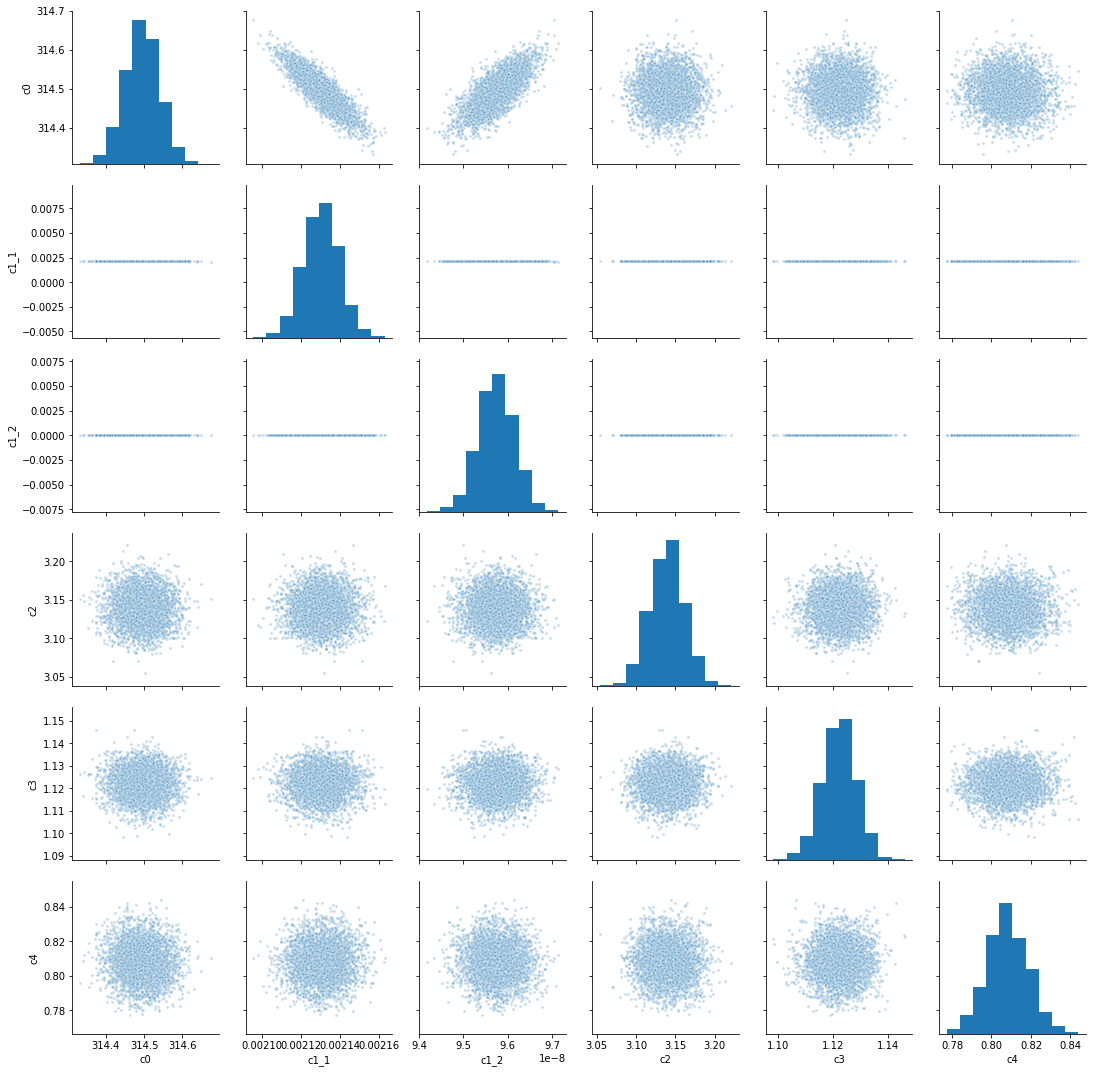

In [85]:
# Make pair plots of the posteriors over all parameters of the model.
df = pandas.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [86]:
# Create a list of observed and unobserved days 
days = list(data.Deltas)
day = days[-1]
for i in range(n_future):
    day += 7
    days.append(day)
# Prediction day
days_to_years(days[-1], date = True)

2058-01-05


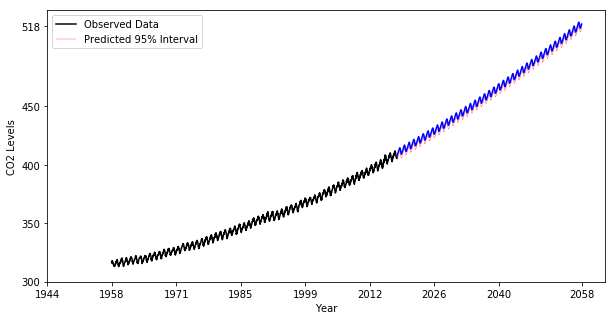

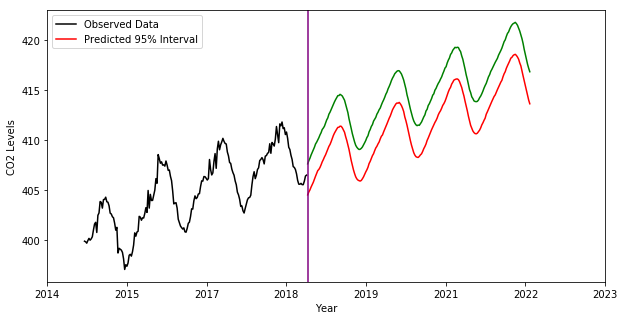

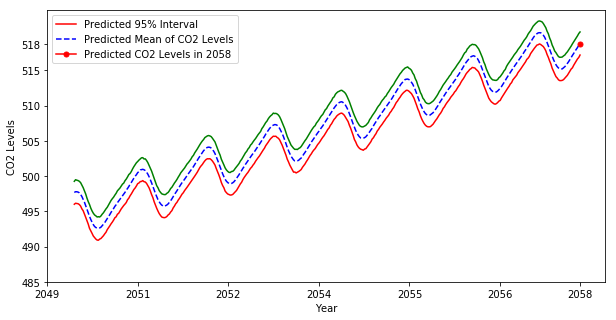

In [199]:
# Plot general trend predictions
pred = samples['x_future']

# Compute 95% interval of the predicted values
prediction_interval = np.percentile(pred, axis=0, q=[2.5, 50.0, 97.5])

# Plot 95% interval of predictions
plt.figure(figsize=(10, 5))
plt.plot(days[0: n], data["CO2"][0:n], 'k-', label='Observed Data')

# Mean
plt.plot(
    days[n:n+n_future],prediction_interval[1,:],
     'b-', label='Predicted Mean of CO2 Levels')

plt.legend()
# Change tick labels to years
locs, labels = plt.xticks() 
locs = np.append(locs[:-2],days[-1])
plt.xticks(locs, [days_to_years(loc) for loc in locs])
l, lab = plt.yticks() 
l = np.append(l[:-2],prediction_interval[1,:][-1])
plt.yticks(l, [int(location) for location in l])
plt.xlabel('Year')
plt.ylabel('CO2 Levels')
plt.show()

# Plot zoomed in trend
plt.figure(figsize=(10, 5))
plt.plot(days[n-200: n], data["CO2"][n-200:n], 'k-', label='Observed Data')


# Lower range
plt.plot(
    days[n:n+200],prediction_interval[0,:][:200],
     'r-', label='Predicted 95% Interval')

# Upper range
plt.plot(
    days[n:n+200], prediction_interval[2,:][:200],
     'g-')

plt.axvline(days[n], color='purple')
plt.legend()
locs, labels = plt.xticks() 
plt.xticks(locs, [days_to_years(loc) for loc in locs])
plt.xlabel('Year')
plt.ylabel('CO2 Levels')
plt.show()

# Plot 1958 CO2 prediction rates
plt.figure(figsize=(10, 5))
# Lover Range
plt.plot(
    days[n+n_future-400:n+n_future],prediction_interval[0,:][-400:],
     'r-', label='Predicted 95% Interval')

# Mean
plt.plot(
    days[n+n_future-400:n+n_future],prediction_interval[1,:][-400:],
     'b--', label='Predicted Mean of CO2 Levels')
# Upper Range
plt.plot(
    days[n+n_future-400:n+n_future],prediction_interval[2,:][-400:],
     'g-')
plt.plot(days[-1], prediction_interval[1,:][-1], marker='o', markersize=5, color="red", label='Predicted CO2 Levels in 2058')

plt.legend()
locs, labels = plt.xticks() 
locs = np.append(locs[:-2],days[-1])
plt.xticks(locs, [days_to_years(loc) for loc in locs])
l, lab = plt.yticks() 
l = np.append(l[:-2],prediction_interval[1,:][-1])
plt.yticks(l, [int(location) for location in l])
plt.xlabel('Year')
plt.ylabel('CO2 Levels')
plt.show()

In [114]:
print "CO2 levels in 2058 will be ", prediction_interval[1,:][-1], "ppm."
print "The 95% confidence interval is ", prediction_interval[0,:][-1], "to ", prediction_interval[2,:][-1]

CO2 levels in 2058 will be  518.7640554361262 ppm.
The 95% confidence interval is  517.1806031965406 to  520.454032250584


In [218]:
# Find predicted value for CO2 = 450
for i in range(len(prediction_interval[0,:])): 
    if int(prediction_interval[1,:][i])==450: #change to 0 to get lower bound
        print "The level of CO2 will be at 450 ppm in ", days_to_years(days[n+i])
        print "Confidence interval: ", prediction_interval[0,:][i], prediction_interval[2,:][i]
        break


The level of CO2 will be at 450 ppm in  2034
Confidence interval:  448.4478609002681 451.61936122470604


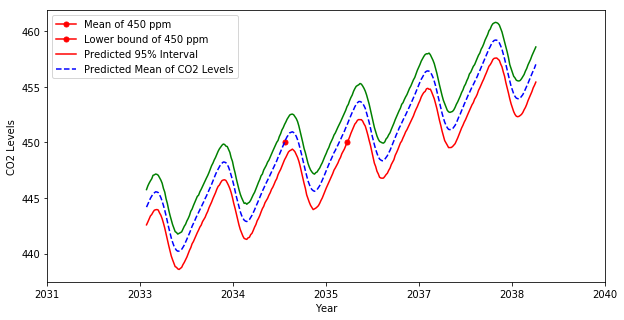

In [191]:
# Plot 450 ppm predicitons
plt.figure(figsize=(10, 5))
plt.plot(days[n+806], 450, marker='o', markersize=5, color="red", label='Mean of 450 ppm')
plt.plot(days[n+854], 450, marker='o', markersize=5, color="red",label='Lower bound of 450 ppm')
# Lower range
plt.plot(
    days[n+700:n+1000],prediction_interval[0,:][700:1000],
     'r-', label='Predicted 95% Interval')
# Mean
plt.plot(
     days[n+700:n+1000],prediction_interval[1,:][700:1000],
     'b--', label='Predicted Mean of CO2 Levels')

# Upper range
plt.plot(
    days[n+700:n+1000], prediction_interval[2,:][700:1000],
     'g-')

locs, labels = plt.xticks() 
plt.xticks(locs, [days_to_years(loc)+1 for loc in locs])
plt.xlabel('Year')
plt.ylabel('CO2 Levels')
plt.legend()
plt.show()

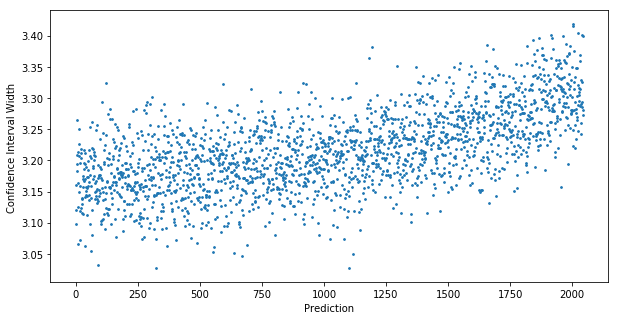

In [213]:
# Calculate and plot confidence interval widths
intervals = []
for i in range(len(prediction_interval[2,:])):
    subtract= prediction_interval[2,:][i]- prediction_interval[0,:][i]
    intervals.append(subtract)
    
plt.figure(figsize=(10, 5))
plt.scatter(range(len(prediction_interval[2,:])), intervals, s =3) 
plt.ylabel('Confidence Interval Width ')
plt.xlabel('Prediction')
plt.show()
